In [1]:
!pip install matplotlib

In [2]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [3]:
torch.set_printoptions(precision=4, sci_mode=False)

In [4]:
from parse_QP import my_callback, parse_qplib_file

In [5]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.05)

# Optimize
grb_model.optimize(my_callback)

Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 9124 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 64 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.01s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Pres

In [6]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.49055482068657474, 0.0, 0.0, 0.09207045008492966, 0.0, 0.0, 0.06558348815658188, 0.2063472207852159, 0.0, 0.14544402028669787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, 0.0, 0.0, 1.0, 1.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [7]:
# Define a maximum finite bound for replacing infinities
max_finite_bound = 1e5

# Extract bounds and handle infinities
variable_bounds = {}
for var in grb_model.getVars():
    lower_bound = var.LB
    upper_bound = var.UB
    
    # Replace infinite bounds with finite values
    if lower_bound == float('-inf'):
        lower_bound = -max_finite_bound
    if upper_bound == float('inf'):
        upper_bound = max_finite_bound
    
    variable_bounds[var.VarName] = {'Lower': lower_bound, 'Upper': upper_bound}

In [8]:
data = parse_qplib_file('0031')
A, b_vector, E, d_vector, Q = data['A'], data['b_vector'], data['E'], data['d'], data['Q']
variables_info = [v[0] for v in data['variables_info']]
binary_indices, variable_indices = data['binary_indices'], data['variable_indices']
m, n = A.shape
row_indices, col_indices = np.nonzero(A); edge_weights = A[row_indices, col_indices]
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])
continuous_indices, binary_indices = np.where(variable_types == 0)[0], np.where(variable_types == 1)[0]
n_continuous, n_binary, n_variables = len(continuous_indices), len(binary_indices), len(continuous_indices)+len(binary_indices)
variable_types_tensor = torch.tensor(variable_types)
variable_lower_bounds = torch.tensor([variable_bounds[var_name]['Lower'] for var_name in variable_bounds], dtype=torch.float)
variable_upper_bounds = torch.tensor([variable_bounds[var_name]['Upper'] for var_name in variable_bounds], dtype=torch.float)
for i, vtype in enumerate(variable_types_tensor):
    if vtype == 1.0: variable_lower_bounds[i], variable_upper_bounds[i] = 0.0, 1.0

In [9]:
from generate_solutions import load_or_generate_solutions, generate_infeasible_solutions, generate_infeasible_solutions, generate_infeasible_nonintegral_solutions

num_samples = 5000

feasible_solutions, feasible_costs, \
infeasible_solutions, infeasible_costs, \
infeasible_nonintegral_solutions, infeasible_nonintegral_costs = load_or_generate_solutions(
    generate_new=False,
    feasible_data_file='feasible_data.pkl',
    infeasible_data_file='infeasible_data.pkl',
    infeasible_nonintegral_data_file='infeasible_nonintegral_data.pkl',
    A=A, E=E, Q=Q, variables_info=variables_info, b_vector=b_vector, d_vector=d_vector,
    generate_feasible_solutions=generate_infeasible_solutions,
    generate_infeasible_solutions=generate_infeasible_solutions,
    generate_infeasible_nonintegral_solutions=generate_infeasible_nonintegral_solutions
)


Loaded existing feasible solutions from file.
Loaded existing infeasible solutions from file.
Loaded existing infeasible non-integral solutions from file.


In [126]:
import torch
import torch.nn as nn
from train_eval import train, test
from data_preparation import prepare_data
from networks import JointGNN

batch_size=128
device = 'cuda'
train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=batch_size, device=device
)

model = JointGNN(hidden_channels_obj=128, hidden_channels_cons=128, decoder_hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


criterion_mse = nn.MSELoss()
criterion_bce = nn.BCELoss()

num_epochs = 500

# Evaluate before training
initial_test_results = test(test_loader, model, criterion_mse, criterion_bce, device=device)
print("Before training, Test Loss:", initial_test_results[0],
      "Recon Loss:", initial_test_results[1],
      "Cost Loss:", initial_test_results[2],
      "Constraint Loss:", initial_test_results[3],
      "Integrality Loss:", initial_test_results[4])

train_total_losses = []
train_recon_losses = []
train_cost_losses = []
train_constraint_losses = []
train_integrality_losses = []

test_total_losses = [initial_test_results[0]]
test_recon_losses = [initial_test_results[1]]
test_cost_losses = [initial_test_results[2]]
test_constraint_losses = [initial_test_results[3]]
test_integrality_losses = [initial_test_results[4]]

for epoch in range(1, num_epochs + 1):
    train_results = train(train_loader, model, optimizer, criterion_mse, criterion_bce, device=device)
    test_results = test(test_loader, model, criterion_mse, criterion_bce, device=device)

    tr_total, tr_recon, tr_cost, tr_const, tr_int = train_results
    te_total, te_recon, te_cost, te_const, te_int = test_results

    train_total_losses.append(tr_total)
    train_recon_losses.append(tr_recon)
    train_cost_losses.append(tr_cost)
    train_constraint_losses.append(tr_const)
    train_integrality_losses.append(tr_int)

    test_total_losses.append(te_total)
    test_recon_losses.append(te_recon)
    test_cost_losses.append(te_cost)
    test_constraint_losses.append(te_const)
    test_integrality_losses.append(te_int)

    if epoch % 5==0:
        print(f"Epoch {epoch}, "
              f"Train Loss: {tr_total:.4f}, Recon: {tr_recon:.4f}, Cost: {tr_cost:.4f}, Const: {tr_const:.4f}, Int: {tr_int:.4f} "
              f"| Test Loss: {te_total:.4f}, Recon: {te_recon:.4f}, Cost: {te_cost:.4f}, Const: {te_const:.4f}, Int: {te_int:.4f}")

/opt/conda/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Before training, Test Loss: 4644.8872830979735 Recon Loss: 0.12555977557908493 Cost Loss: 4641.722553895511 Constraint Loss: 2.343696497013752 Integrality Loss: 0.6954762194847597
Epoch 5, Train Loss: 97.5478, Recon: 0.0006, Cost: 97.0139, Const: 0.2051, Int: 0.3281 | Test Loss: 81.2771, Recon: 0.0004, Cost: 80.9208, Const: 0.0730, Int: 0.2830
Epoch 10, Train Loss: 69.9787, Recon: 0.0002, Cost: 69.7457, Const: 0.0414, Int: 0.1914 | Test Loss: 65.7802, Recon: 0.0002, Cost: 65.5563, Const: 0.0493, Int: 0.1743
Epoch 15, Train Loss: 46.5547, Recon: 0.0003, Cost: 46.3440, Const: 0.0583, Int: 0.1522 | Test Loss: 48.7127, Recon: 0.0002, Cost: 48.5456, Const: 0.0328, Int: 0.1341
Epoch 20, Train Loss: 29.9921, Recon: 0.0003, Cost: 29.8514, Const: 0.0173, Int: 0.1231 | Test Loss: 33.8763, Recon: 0.0002, Cost: 33.7497, Const: 0.0162, Int: 0.1102
Epoch 25, Train Loss: 26.7237, Recon: 0.0002, Cost: 26.5967, Const: 0.0195, Int: 0.1073 | Test Loss: 27.7646, Recon: 0.0002, Cost: 27.6554, Const: 0.0135

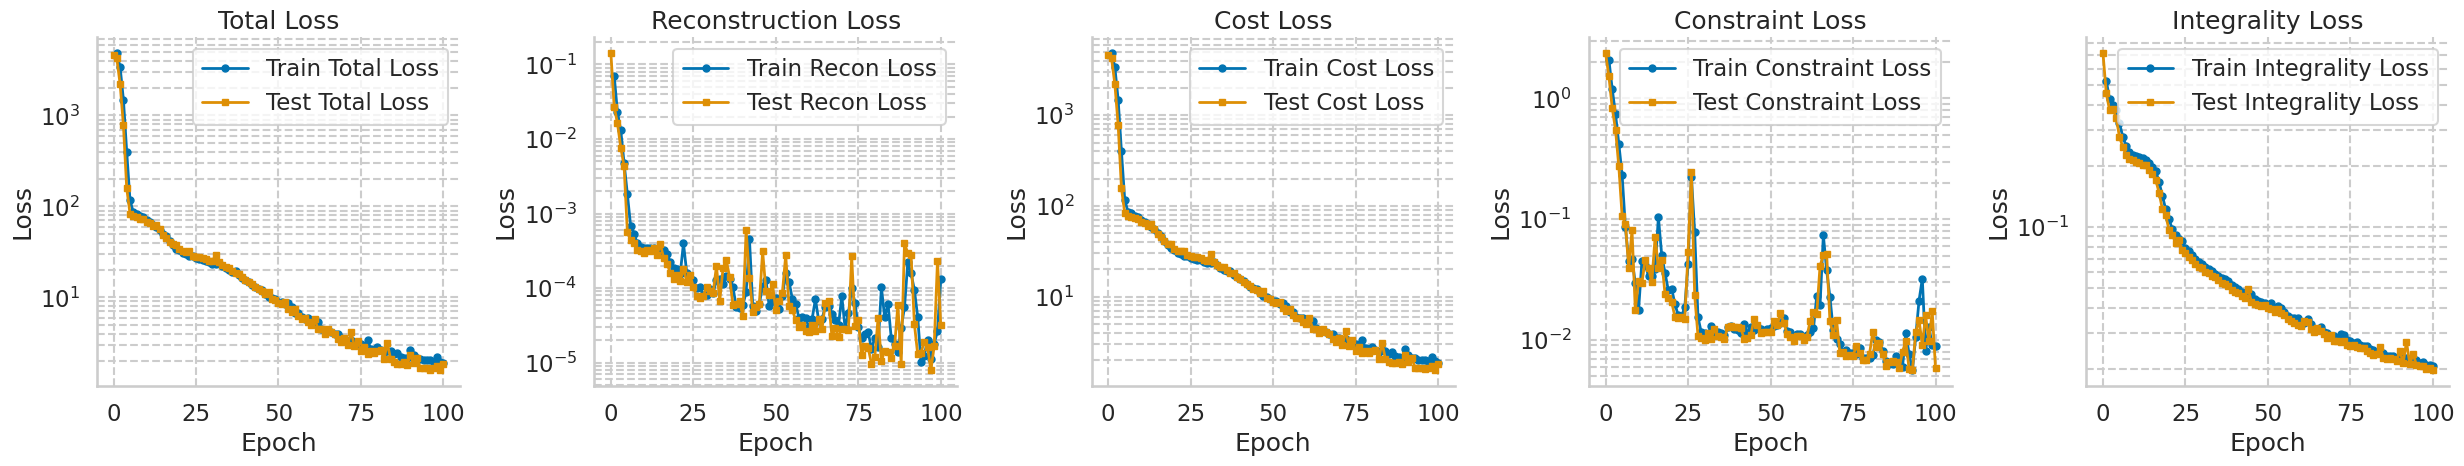

In [47]:
from plotting import plot_losses
import seaborn as sns

plot_losses(
    num_epochs,
     train_total_losses, train_recon_losses, train_cost_losses, train_constraint_losses, train_integrality_losses,
     test_total_losses, test_recon_losses, test_cost_losses, test_constraint_losses, test_integrality_losses
)

In [12]:
# from plotting import plot_predictions_vs_actuals

# model.eval()


# plot_predictions_vs_actuals(model, test_loader, device=device, num_samples_to_show=1000)

In [107]:
_, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=1, device=device
)

# data_obj_batch, data_feas_batch = next(iter(test_loader))
# data_obj_batch = data_obj_batch.to(device)
# data_feas_batch = data_feas_batch.to(device)

In [108]:
for data_obj_batch, data_feas_batch in test_loader:
    data_obj_batch = data_obj_batch.to(device)
    data_feas_batch = data_feas_batch.to(device)
    
    # Convert the batched data back into a list of individual Data objects
    feas_data_list = data_feas_batch.to_data_list()
    
    # Iterate over each graph in the batch
    for single_feas_data in feas_data_list:
        if torch.abs(single_feas_data.y_constraints[-1]) > 0:
            print("Found an infeasible sample in this batch.")
            # Use single_feas_data (and corresponding object data if needed)
            # e.g., process_sample(single_obj_data, single_feas_data)
            break
    else:
        # If we didn't break, it means we didn't find a suitable sample in this batch
        continue
    # If we broke out of the inner loop, break out of the outer loop as well
    break


Found an infeasible sample in this batch.


In [109]:
test(test_loader, model, criterion_mse, criterion_bce, device=device)

(1.8328672914289978,
 3.1607980224517756e-05,
 1.8072090189680208,
 0.0058344567007489745,
 0.01979220025084021)

In [110]:
x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

In [111]:
x_hat

tensor([    0.0329,     0.0088,     0.0244,     0.1033,     0.0249,     0.5603,
            0.0004,     0.0004,     0.0004,     0.0636,     0.0004,     0.1186,
            0.1237,     0.0285,     0.0191,     0.0004,     0.0413,     0.0045,
            0.0003,     0.0718,     0.3020,     0.0014,     0.0015,     0.1190,
            0.0444,     0.0007,     0.0046,     0.0014,     0.0014,     0.0616,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.9949,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.9949,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [112]:
data_feas_batch.y_x

tensor([0.0330, 0.0069, 0.0231, 0.1007, 0.0237, 0.5661, 0.0000, 0.0000, 0.0000,
        0.0676, 0.0000, 0.1140, 0.1178, 0.0280, 0.0175, 0.0000, 0.0411, 0.0030,
        0.0000, 0.0698, 0.2837, 0.0000, 0.0000, 0.1167, 0.0438, 0.0000, 0.0032,
        0.0000, 0.0000, 0.0619, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 1.0000, -0.0000, -0.0000, 0.0000,
        0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')

In [113]:
x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

In [114]:
data_feas_batch.y_constraints

tensor([-3.0000,  0.0330,  0.0069,  0.0231,  0.1007,  0.0237, -0.4339,  0.0000,
         0.0000,  0.0000,  0.0676,  0.0000,  0.1140,  0.1178,  0.0280,  0.0175,
         0.0000,  0.0411,  0.0030,  0.0000,  0.0698, -0.7163,  0.0000,  0.0000,
         0.1167,  0.0438,  0.0000,  0.0032,  0.0000,  0.0000,  0.0619,  0.7216],
       device='cuda:0')

In [128]:
mean_x

tensor([0.1128, 0.1039, 0.1095, 0.1308, 0.1096, 0.5475, 0.1012, 0.1012, 0.1012,
        0.1225, 0.1011, 0.1389, 0.1415, 0.1111, 0.1075, 0.1012, 0.1149, 0.1698,
        0.1576, 0.1385, 0.3439, 0.1691, 0.1699, 0.1948, 0.1527, 0.1638, 0.1692,
        0.1690, 0.1692, 0.1452, 0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.1573,
        0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.0811,
        0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.1573, 0.0811, 0.0811, 0.0811,
        0.0811, 0.0811, 0.0811, 0.0811, 0.0811, 0.0811], device='cuda:0')

In [129]:
std_x

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [115]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

# Suppose alpha (step size) and mu (penalty weight) are defined
alpha = 0.01
mu = 10.0

model.eval()

# ----------------------
# Extract initial z from the model
# ----------------------
with torch.no_grad():
    # Encode to get z_obj and z_cons
    z_obj = model.encoder_obj(data_obj_batch)  # (N_obj_nodes, hidden_channels_obj)
    z_cons_var, z_cons_constraints = model.encoder_cons(data_feas_batch)  # Encoded constraint graph

# Create z_var by concatenating z_obj_var and z_cons_var
z_obj_var = z_obj[data_obj_batch.variable_mask]  # (num_var_nodes, hidden_channels_obj)
z_var = torch.cat([z_obj_var, z_cons_var], dim=1)  # (num_var_nodes, hidden_channels_obj + hidden_channels_cons)

# Pad constraints to match dimension
concat_dim = z_var.size(1)
z_cons_constraints_padded = F.pad(z_cons_constraints, (0, concat_dim - z_cons_constraints.size(1)))

# Concatenate to form z_shared
z_shared = torch.cat([z_var, z_cons_constraints_padded], dim=0)  # (num_var_nodes + num_cons_nodes, concat_dim)

# Number of variable nodes and constraint nodes
num_var_nodes = z_var.size(0)
num_cons_nodes = z_cons_constraints_padded.size(0)

# We will now treat z_shared as our optimization variable
z = z_shared.clone().detach().requires_grad_(True)

# Get necessary masks and batch
binary_mask = data_obj_batch.binary_mask[data_obj_batch.variable_mask]
batch = data_feas_batch.batch[data_feas_batch.variable_mask]

# ----------------------
# Define helper functions to decode cost and constraints from z
# ----------------------
def decode_from_z(z):
    # Given z, split it back into variable and constraint parts
    z_shared_var = z[:num_var_nodes]            # (num_var_nodes, concat_dim)
    z_shared_constraints = z[num_var_nodes:]    # (num_cons_nodes, concat_dim)
    
    # Decode cost
    z_var_pooled = global_mean_pool(z_shared_var, batch)
    predicted_cost = model.decoder_cost(z_var_pooled).squeeze()     # scalar cost
    
    # Decode constraints
    predicted_constraints = model.decoder_constraints(z_shared_constraints).squeeze()

    # Decode x
    x_hat = model.decoder_x(z_shared_var).squeeze()

    return predicted_cost, predicted_constraints, x_hat

def hat_c_theta(z):
    # Predicted cost
    predicted_cost, _, _ = decode_from_z(z)
    return predicted_cost

def hat_g_theta(z):
    # Predicted constraints
    _, predicted_constraints, _ = decode_from_z(z)
    return predicted_constraints

# ----------------------
# Latent optimization steps
# ----------------------
num_steps = 100  # number of gradient steps
for step in range(num_steps):
    # Zero the gradient
    if z.grad is not None:
        z.grad.zero_()
    
    # Compute objective:
    # c(z) + mu * [ sum of squared positive parts of inequality constraints + squared equality constraint ]
    c_z = hat_c_theta(z)                      # scalar
    g_z = hat_g_theta(z)                      # (num_cons_nodes,)

    # Assume last element of g_z is equality constraint, the rest are inequality constraints
    if g_z.dim() == 0:
        # If there's only one constraint and it's equality
        g_pos = torch.tensor([]).to(z)  # no inequality constraints
        eq_constraint = g_z
    else:
        g_pos = F.relu(g_z[:-1])        # inequality constraints
        eq_constraint = g_z[-1]         # equality constraint

    # constraint_penalty = ||max(g(z)_inequality, 0)||^2 + (g(z)_equality)^2
    constraint_penalty = (g_pos**2).sum() + eq_constraint.pow(2)
    loss = c_z + mu * constraint_penalty

    # Compute gradients
    loss.backward()

    # Gradient update for z: z = z - alpha * grad_z
    with torch.no_grad():
        z -= alpha * z.grad
        z.requires_grad_(True)

    if (step+1) % 10 == 0:
        print(f"Step {step+1}/{num_steps}: loss={loss.item():.4f}, cost={c_z.item():.4f}, constraint_penalty={constraint_penalty.item():.4f}")

# After optimization, decode final x
_, _, x_hat_final = decode_from_z(z.detach())
print("Optimized x:", x_hat_final)


Step 10/100: loss=2.1293, cost=2.1293, constraint_penalty=0.0000
Step 20/100: loss=2.0201, cost=2.0201, constraint_penalty=0.0000
Step 30/100: loss=1.9109, cost=1.9109, constraint_penalty=0.0000
Step 40/100: loss=1.8018, cost=1.8018, constraint_penalty=0.0000
Step 50/100: loss=1.6926, cost=1.6926, constraint_penalty=0.0000
Step 60/100: loss=1.5834, cost=1.5834, constraint_penalty=0.0000
Step 70/100: loss=1.4743, cost=1.4743, constraint_penalty=0.0000
Step 80/100: loss=1.3651, cost=1.3651, constraint_penalty=0.0000
Step 90/100: loss=1.2559, cost=1.2559, constraint_penalty=0.0000
Step 100/100: loss=1.1467, cost=1.1467, constraint_penalty=0.0000
Optimized x: tensor([ 0.0210, -0.0053,  0.0125,  0.0947,  0.0130,  0.5549, -0.0158, -0.0158,
        -0.0158,  0.0551, -0.0158,  0.1093,  0.1144,  0.0166,  0.0072, -0.0158,
         0.0294, -0.0069, -0.0114,  0.0632,  0.2885, -0.0100, -0.0099,  0.1103,
         0.0324, -0.0108, -0.0068, -0.0101, -0.0100,  0.0496, -0.0035, -0.0035,
        -0.0035,

In [125]:
# Suppose x_star is obtained from Dec(z_opt, model)
# Ensure x_star is on CPU for simplicity:
x_star = x_hat_final.detach().cpu().numpy()

tolerance = 1e-6

# Check inequalities: A x_star <= b
Ax = A @ x_star
feasible_ineq = np.all(Ax <= b_vector + tolerance)

# Check equalities: E x_star = d
Ex = E @ x_star
feasible_eq = np.all(np.abs(Ex - d_vector) <= tolerance)

if feasible_ineq and feasible_eq:
    print("Solution is feasible.")
else:
    print("Solution is not feasible.")
    if not feasible_ineq:
        violated_amount = (Ax - b_vector)[Ax > b_vector + tolerance]
        print("Inequality constraints violated. Violations:", violated_amount)
    if not feasible_eq:
        eq_violations = (Ex - d_vector)[np.abs(Ex - d_vector) > tolerance]
        print("Equality constraints violated. Violations:", eq_violations)


Solution is not feasible.
Inequality constraints violated. Violations: [0.02447358 0.01601172 0.09819293 0.01649325 0.05855973 0.11278865
 0.11785569 0.02009672 0.01071786 0.0329024  0.0667238  0.11380202
 0.03589035 0.05307584]
Equality constraints violated. Violations: [0.41193836]
